In [1]:
import pandas as pd
import numpy as np
import json
from pandas import json_normalize
# from google.colab import files
import pyarrow.parquet as pq
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import warnings
warnings.filterwarnings('ignore')

In [2]:
def split_dataframe_by_quarter_and_year(dataframe, date_column):
    # Ensure the date_column is in datetime format
    dataframe[date_column] = pd.to_datetime(dataframe[date_column])

    # Group by year and quarter
    dataframe['quarter'] = dataframe[date_column].dt.to_period('Q')
    grouped = dataframe.groupby(['quarter', dataframe[date_column].dt.year])

    # Initialize the result dictionary
    result_dict = {}

    # Iterate over the groups and store DataFrames in the result dictionary
    for (quarter, year), group in grouped:
        key = f"{year}-{quarter.quarter}"
        result_dict[key] = group.copy()

    return result_dict

In [3]:
df_full = pd.read_parquet('data/df_full.parquet')
#Drop some column
tns=df_full.copy()
tns=tns.drop(columns=['center','product_json','product','qty'])
tns['payment_date']=pd.to_datetime(tns['payment_date'])
# drop df_full[df_full['paid_amount']<0
tns=tns[tns['paid_amount']>0]
tns=tns.reset_index(drop=True)
tns_split = split_dataframe_by_quarter_and_year(tns, 'payment_date')
df_2Q23 = tns_split['2023-2']
df_2Q23.head()


,payment_date,ent,total_amount,discount,paid_amount,trans_origin_type,0C1CC4,0C4C43,0C4C4C,0C4C4Q,...,XC4CCQ,XC4CCW,XCECC4,XCECCJ,XCECCQ,XCJCC3,XCJCCZ,XCQCC4,XP9LI,quarter
2200369,2023-04-01,TCC4EJQE1WP,492000.0,0.0,492000.0,online,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2023Q2
2200370,2023-04-01,TCC4E3QERCI,497000.0,2500.0,494500.0,online,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2023Q2
2200371,2023-04-01,TCCEE4R1CRP,228000.0,189000.0,39000.0,online,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2023Q2
2200372,2023-04-01,TCCE4RERCQ5,228000.0,189000.0,39000.0,online,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2023Q2
2200373,2023-04-01,TCC4WZZEQWY,1379000.0,0.0,1379000.0,online,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2023Q2


In [4]:
df_1Q23 = tns_split['2023-1']
df_2023 = pd.concat([df_1Q23,df_2Q23])
df_2023.head()

,payment_date,ent,total_amount,discount,paid_amount,trans_origin_type,0C1CC4,0C4C43,0C4C4C,0C4C4Q,...,XC4CCQ,XC4CCW,XCECC4,XCECCJ,XCECCQ,XCJCC3,XCJCCZ,XCQCC4,XP9LI,quarter
2038751,2023-01-01,TCC4QCZJZQI,590000.0,2500.0,587500.0,online,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2023Q1
2038752,2023-01-01,TCC4QCE34Z7,243000.0,2500.0,240500.0,online,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2023Q1
2038753,2023-01-01,TCC44Q3JQQ2,1792000.0,0.0,1792000.0,online,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2023Q1
2038754,2023-01-01,TCC41JJZCRF,3025000.0,0.0,3025000.0,online,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2023Q1
2038755,2023-01-01,TCC4JZCJ1JK,198000.0,0.0,198000.0,online,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2023Q1


In [5]:
df_2023_2 = df_2023.copy()
df_2023_2.drop(columns=['payment_date', 'total_amount', 'discount', 'paid_amount', 'trans_origin_type', 'quarter'], inplace=True)

# sum the qty of each product column by customer_id
df_2023_2 = df_2023_2.groupby('ent').sum()
df_2023_2.reset_index(inplace=True)
df_2023_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100251 entries, 0 to 100250
Columns: 478 entries, ent to XP9LI
dtypes: int64(477), object(1)
memory usage: 365.6+ MB


In [6]:
df_2023_2.set_index('ent', inplace=True)
df_2023_2 = df_2023_2.loc[:, (df_2023_2 != 0).any(axis=0)]
df_2023_2.head()

,0C4CCJ,0C4CCZ,0CECCR,0CECCZ,27T6,2C1CC3,2C1CCQ,2C1CCW,2C1CCZ,4144,...,SCJCC4,UC4CC1,UC4CCE,XC4CC4,XC4CCE,XCECCJ,XCECCQ,XCJCC3,XCJCCZ,XCQCC4
ent,,,,,,,,,,,,,,,,,,,,,
8CCCCCC4R1F,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
BC14413K,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
BCCCCRE3C4F,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
BCCCCRE3Q40,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
BCCCCREW3WY,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


# Example 2023 Data

## EDA

In [7]:
df = df_2023_2.copy()
df.describe().T.sort_values(by='mean', ascending=False)

,count,mean,std,min,25%,50%,75%,max
6CQC41,100251.0,0.749060,1.803577,0.0,0.0,0.0,1.0,50.0
BC4CC4,100251.0,0.356575,1.494157,0.0,0.0,0.0,0.0,72.0
7C4CC4,100251.0,0.289872,0.850737,0.0,0.0,0.0,0.0,33.0
5C4CCE,100251.0,0.264726,0.702922,0.0,0.0,0.0,0.0,16.0
BC4C41,100251.0,0.255938,0.790159,0.0,0.0,0.0,0.0,20.0
...,...,...,...,...,...,...,...,...
E1CW,100251.0,0.000010,0.003158,0.0,0.0,0.0,0.0,1.0
BCQCCE,100251.0,0.000010,0.003158,0.0,0.0,0.0,0.0,1.0
4R4Q,100251.0,0.000010,0.003158,0.0,0.0,0.0,0.0,1.0
9C4CC1,100251.0,0.000010,0.003158,0.0,0.0,0.0,0.0,1.0


### Purchase/Usage Ranking

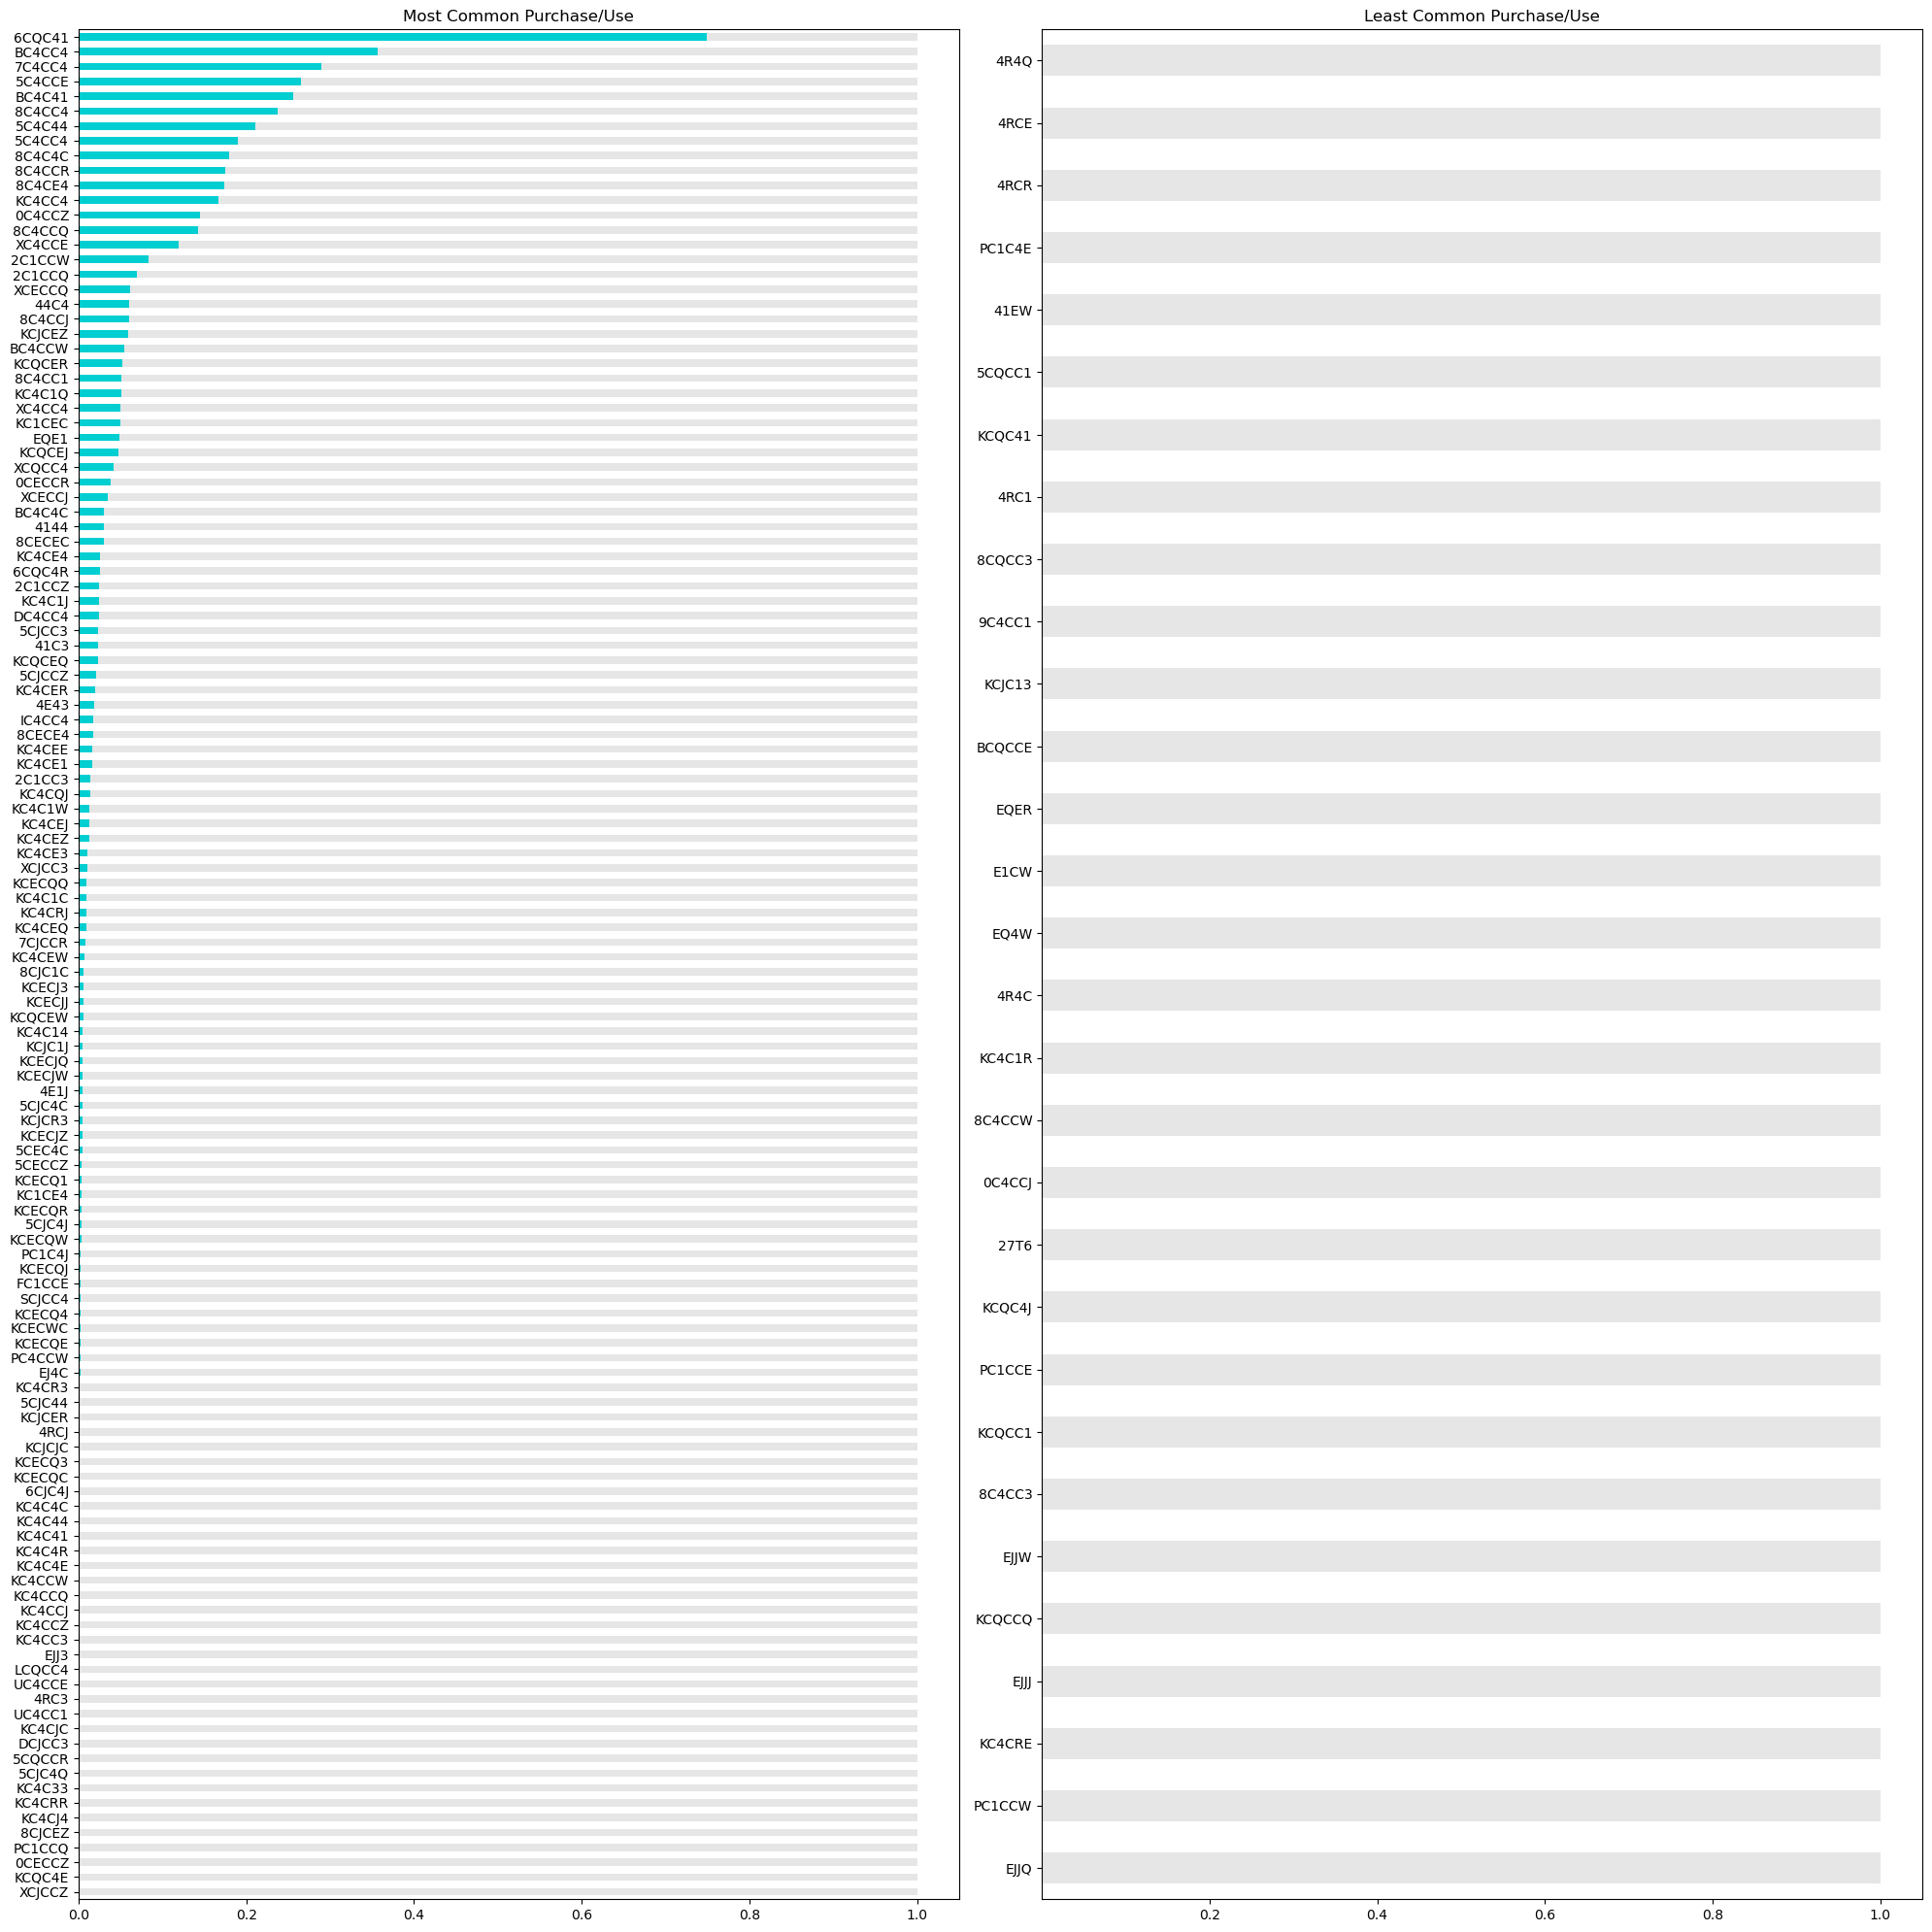

In [8]:
temp = df.mean().sort_values().to_frame().rename({0:'yes'}, axis=1)
temp['no'] = 1 - temp['yes']

fig, axes = plt.subplots(1,2, figsize=(20,20), tight_layout=True)
colors = ['darkturquoise','.9']
temp[30:].plot.barh(stacked=True, color=colors, ax=axes[0], title='Most Common Purchase/Use', legend=False)
temp[:30].sort_values('yes', ascending=False).plot.barh(stacked=True, color=colors, ax=axes[1], title='Least Common Purchase/Use', legend=False)
# plt.savefig('plots/usage.png',dpi=120)
plt.show()

## Product Recommendation

### 1) Cosine Similarity

In [9]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors

# Transpose the DataFrame
product_matrix = df.transpose()

# Calculate cosine similarity between products
cosine_sim = cosine_similarity(product_matrix)

# Generate recommendations for each customer
num_recommendations = 2
recommendations = {}

for customer in df.index:
    purchased_products = df.loc[customer]
    recommendations[customer] = []
    
    for product in product_matrix.index:
        if purchased_products[product] == 0:  # Product not purchased
            sim_scores = cosine_sim[product_matrix.index.get_loc(product)]
            similar_products = product_matrix.index[sim_scores.argsort()[::-1]][1:]  # Exclude the product itself
            recommended_product = next((p for p in similar_products if purchased_products[p] == 1), None)
            
            if recommended_product:
                recommendations[customer].append(recommended_product)
                if len(recommendations[customer]) >= num_recommendations:
                    break

# recommendations to dataframe
recommendations_df = pd.DataFrame.from_dict(recommendations, orient='index').reset_index()
recommendations_df.columns = ['customer_id', 'recommendation_1', 'recommendation_2']
recommendations_df.head()

,customer_id,recommendation_1,recommendation_2
0,8CCCCCC4R1F,KC4C1Q,BC4C41
1,BC14413K,None,None
2,BCCCCRE3C4F,2C1CCQ,2C1CCQ
3,BCCCCRE3Q40,0C4CCZ,6CQC41
4,BCCCCREW3WY,KC1CEC,8C4CCR


In [14]:
from pyvis.network import Network

# Create a Network instance
net = Network(directed=False, height='800px', width='100%', bgcolor='white')

# Add nodes (products) to the network
for product in product_matrix.index:
    net.add_node(product, label=product)

# Add edges (similarity relationships) to the network
for i, product1 in enumerate(product_matrix.index):
    for j, product2 in enumerate(product_matrix.index):
        if i != j and cosine_sim[i, j] > 0.6:
            similarity = cosine_sim[i, j]
            net.add_edge(product1, product2, title=f"Cosine Similarity: {similarity:.2f}")

# Save the graph as an HTML file
net.save_graph("product_similarity_graph - Cosine.html")

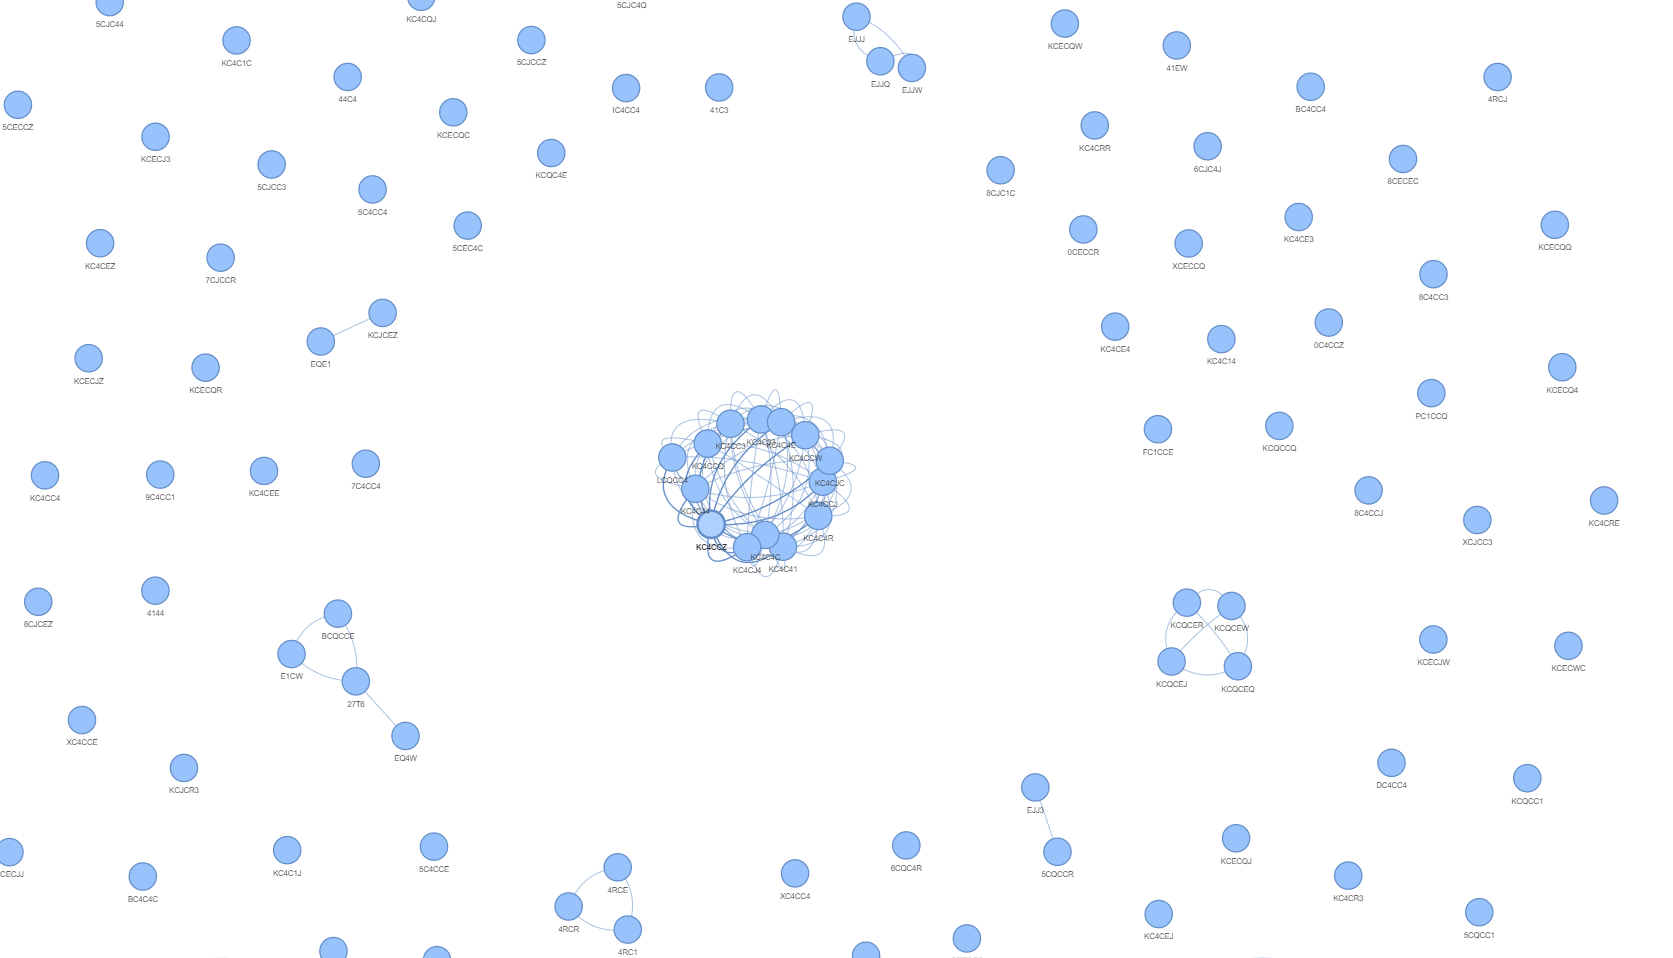

### Jaccard Similarity

In [12]:
from sklearn.metrics import jaccard_score
from itertools import combinations

df2 = df_2023_2.copy()
# buy or not buy each product (1 or 0)
df2[df2 > 0] = 1 # buy
df2[df2 < 0] = 0 # not buy

# Calculate Jaccard Similarity for products
products = df2.columns[1:]
similarities = {}
for product1, product2 in combinations(products, 2):
    sim_score = jaccard_score(df2[product1], df2[product2])
    similarities[(product1, product2)] = sim_score
    similarities[(product2, product1)] = sim_score


In [13]:
import networkx as nx

# Set a similarity threshold to consider products as similar
similarity_threshold = 0.6  # Adjust as needed

# Create a graph of similar products
G = nx.Graph()
for product1, product2 in combinations(products, 2):
    if similarities[(product1, product2)] > similarity_threshold:
        G.add_edge(product1, product2, weight=similarities[(product1, product2)])

# Create a Network object
# nt = Network(height="800px", width="100%", notebook=True, bgcolor="white")
nt = Network(directed=False, height='800px', width='100%', bgcolor='white')

nt.barnes_hut()

# Add nodes and edges to the Network object
for node in G.nodes():
    nt.add_node(node, label=node, title=node, font={"size": 200})

for edge in G.edges(data=True):
    nt.add_edge(edge[0], edge[1], value=edge[2]['weight'], title=f"Jaccard: {edge[2]['weight']:.2f}", font={"size": 200})

# Save and show the Network object
nt.save_graph("product_similarity_graph - Jaccard.html")

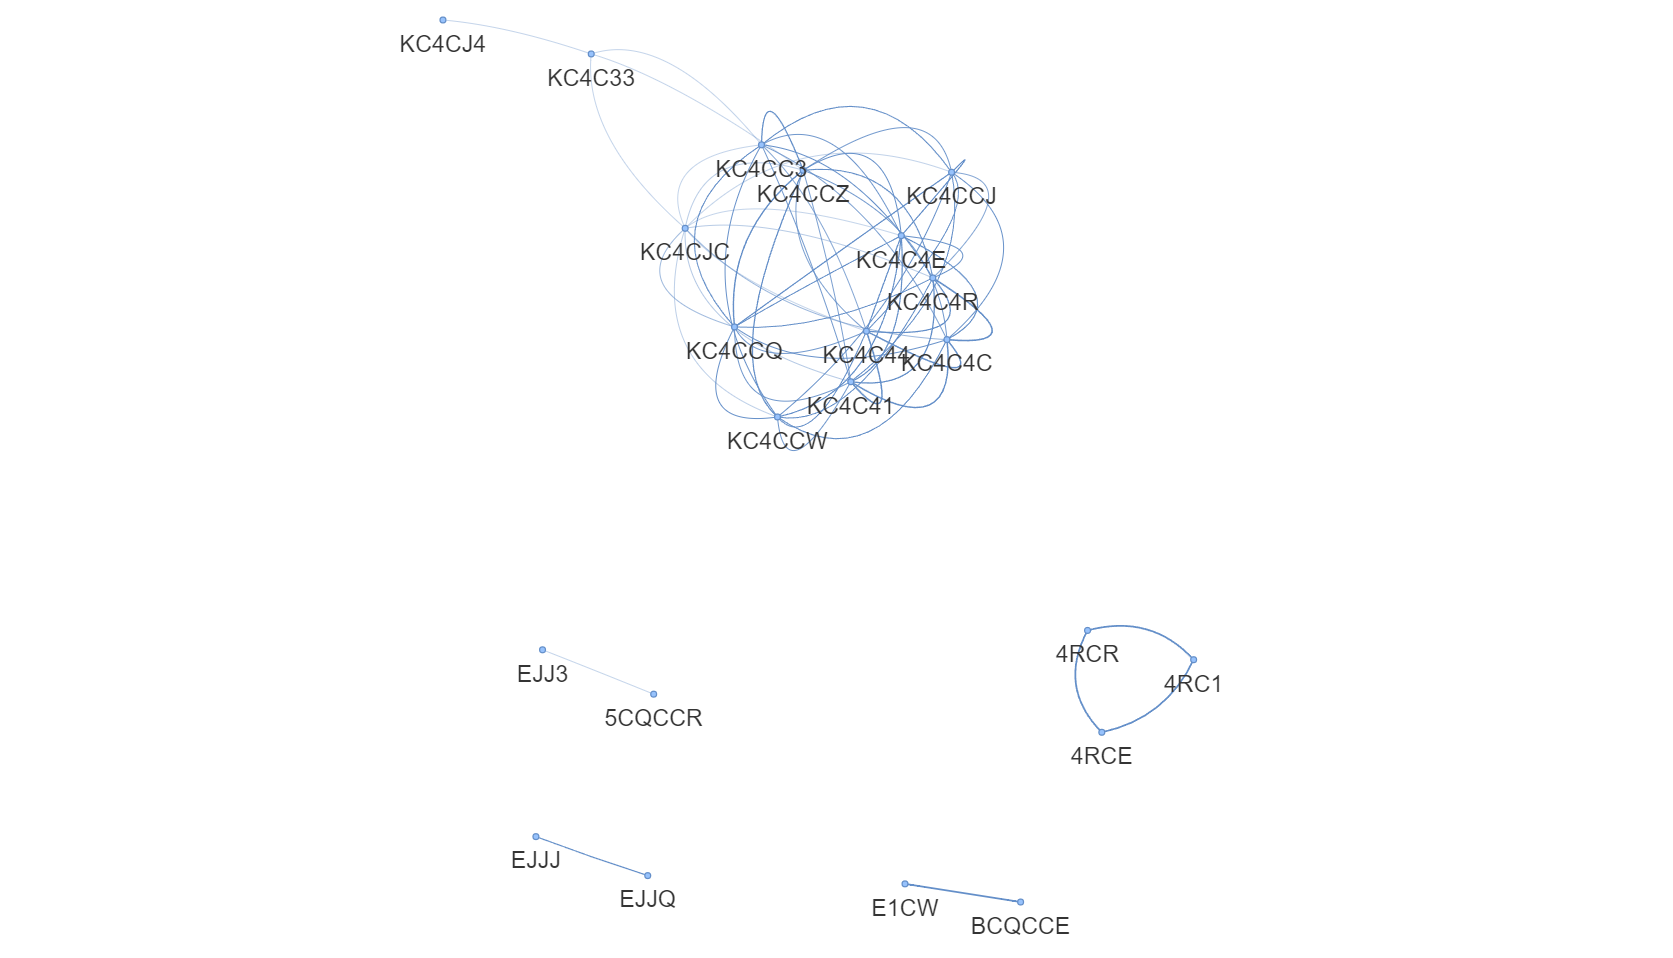